# Imputation Evaluation Notebook
In diesem Notebook vergleichen wir verschiedene Imputationsmethoden für Wetterzeitreihen.
## 1. Setup und Daten laden

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, KNNImputer
from scipy.interpolate import interp1d

# Daten laden
df = pd.read_csv('../data/wetterdaten_top150.csv.gz', compression='gzip', parse_dates=['timestamp'])
df = df.sort_values(['station_id', 'timestamp']).set_index('timestamp')
df.head()

,station_id,tl,rf,ff,ffx,cglo,so_h,rr,rrm,tb10,tb20
timestamp,,,,,,,,,,,
2014-01-01 00:00:00+00:00,2,-2.7,93.0,1.7,2.6,0.0,0.0,0.0,0.0,0.5,1.1
2014-01-01 01:00:00+00:00,2,-2.6,92.0,1.5,3.2,0.0,0.0,0.0,0.0,0.5,1.1
2014-01-01 02:00:00+00:00,2,-2.3,92.0,1.0,2.6,0.0,0.0,0.0,0.0,0.5,1.1
2014-01-01 03:00:00+00:00,2,-2.2,90.0,1.2,3.4,0.0,0.0,0.0,0.0,0.5,1.1
2014-01-01 04:00:00+00:00,2,-2.4,90.0,2.4,3.6,0.0,0.0,0.0,0.0,0.5,1.1


## 2. Künstliche Lücken erzeugen
Funktion zum Einführen von fehlenden Daten in unterschiedlichen Szenarien.

In [2]:
def create_gaps(series, gap_type):
    s = series.copy()
    n = len(s)
    if gap_type == 'kurz':
        lengths = np.random.randint(1, 4, size=5)
    elif gap_type == 'mittel':
        lengths = np.random.randint(4, 25, size=3)
    else:
        lengths = np.random.randint(24, 168, size=2)
    for L in lengths:
        start = np.random.randint(0, n-L)
        s.iloc[start:start+L] = np.nan
    return s

## 3. Imputationsmethoden definieren

In [3]:
methods = {
    'linear': lambda x: x.interpolate(method='time', limit=3),
    'spline2': lambda x: x.interpolate(method='spline', order=2),
    'iterative': lambda x: pd.Series(
        IterativeImputer(max_iter=10, random_state=0)
        .fit_transform(x.values.reshape(-1,1)).ravel(), index=x.index),
    'knn': lambda x: pd.Series(
        KNNImputer(n_neighbors=5)
        .fit_transform(x.values.reshape(-1,1)).ravel(), index=x.index)
}

## 4. Lücken füllen und Performance messen

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
results = []
stations = df['station_id'].unique()[:5]
variables = ['tl','rf','ff','cglo']
scenarios = ['kurz','mittel','lang']

from joblib import Parallel, delayed

def eval_station(station):
    res = []
    df_s = df[df.station_id==station]
    for var in variables:
        orig = df_s[var].dropna()
        for scen in scenarios:
            masked = create_gaps(orig, scen)
            gap_idx = masked[masked.isna()].index
            for name, method in methods.items():
                filled = method(masked)
                valid = gap_idx.intersection(filled.dropna().index)
                if len(valid)==0:
                    mae = rmse = np.nan
                else:
                    y_true = orig.loc[valid]
                    y_pred = filled.loc[valid]
                    mae  = mean_absolute_error(y_true, y_pred)
                    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                res.append((station,var,scen,name,mae,rmse))
    return res

all_results = Parallel(n_jobs=4, verbose=10)(delayed(eval_station)(st) for st in stations)
results_df = pd.DataFrame([row for station_res in all_results for row in station_res],
                          columns=['station','var','scenario','method','MAE','RMSE'])


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [ ]:
import seaborn as sns
pivot = results_df.pivot_table(index='scenario', columns='method', values='MAE', aggfunc='mean')
sns.heatmap(pivot, annot=True)
plt.title('Durchschnittlicher MAE pro Szenario und Methode')
plt.show()

In [6]:
import time
t0 = time.time()
res0 = eval_station(stations[0])
print("Dauer für Station", stations[0], ":", time.time()-t0)

Dauer für Station 2 : 461.9291641712189


In [9]:
from sklearn.impute import IterativeImputer, KNNImputer

def eval_station_fast(station):
    res = []
    df_s = df[df.station_id==station]
    for var in variables:
        # 1) Originalserie
        orig = df_s[var].dropna()
        data = orig.values.reshape(-1,1)

        # 2) Imputer einmalig fitten (mit reduzierten Parametern)
        it_imp  = IterativeImputer(max_iter=3, random_state=0).fit(data)
        knn_imp = KNNImputer(n_neighbors=3).fit(data)

        # 3) Methoden als normale Funktionen
        def imp_linear(x):
            return x.interpolate(method='time', limit=3)

        def imp_iter(x):
            out = it_imp.transform(x.values.reshape(-1,1)).ravel()
            return pd.Series(out, index=x.index)

        def imp_knn(x):
            out = knn_imp.transform(x.values.reshape(-1,1)).ravel()
            return pd.Series(out, index=x.index)

        local_methods = {
            'linear': imp_linear,
            'iterative': imp_iter,
            'knn': imp_knn
        }

        # 4) Gaps erzeugen und nur transform anwenden
        for scen in scenarios:
            masked = create_gaps(orig, scen)
            gap_idx = masked[masked.isna()].index
            for name, method in local_methods.items():
                filled = method(masked)
                valid = gap_idx.intersection(filled.dropna().index)
                if len(valid) == 0:
                    mae = rmse = np.nan
                else:
                    y_true = orig.loc[valid]
                    y_pred = filled.loc[valid]
                    mae  = mean_absolute_error(y_true, y_pred)
                    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                res.append((station, var, scen, name, mae, rmse))
    return res

In [10]:
t0 = time.time()
_ = eval_station_fast(stations[0])
print("Neue Dauer:", time.time()-t0)

Neue Dauer: 2.0495364665985107


In [13]:
results = []
stations = df['station_id'].unique()
variables = ['tl','rf','ff','cglo']
scenarios = ['kurz','mittel','lang']
all_results = Parallel(n_jobs=4, verbose=10)(
    delayed(eval_station_fast)(st) for st in stations
)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    9.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   14.4s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   22.7s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   31.7s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   43.8s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   56.5s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  2.9min finished


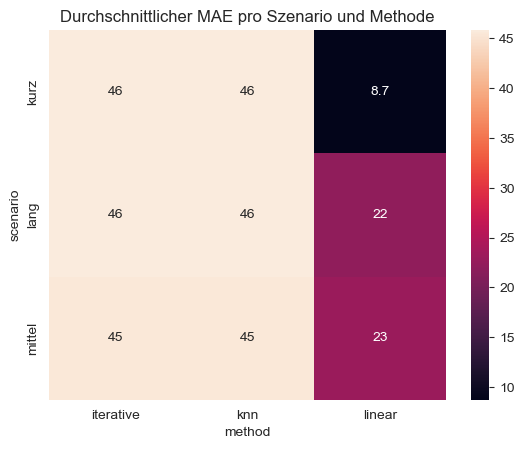

In [14]:
results_df = pd.DataFrame([row for station_res in all_results for row in station_res],
                          columns=['station','var','scenario','method','MAE','RMSE'])
import seaborn as sns
pivot = results_df.pivot_table(index='scenario', columns='method', values='MAE', aggfunc='mean')
sns.heatmap(pivot, annot=True)
plt.title('Durchschnittlicher MAE pro Szenario und Methode')
plt.show()

In [ ]:
df = pd.read_csv(
    '../data/wetterdaten_top150.csv.gz',
    compression='gzip',
    parse_dates=['timestamp']
)

# 2. Index setzen und sortieren
df = (
    df
    .sort_values(['station_id', 'timestamp'])
    .set_index('timestamp')
)

# 3. Lineare Zeit-Interpolation pro Station durchführen
#    limit_direction='both' sorgt dafür, dass auch führende oder
#    abschließende NaNs interpoliert werden, wenn möglich.
df_filled = (
    df
    .groupby('station_id')
    .apply(lambda g: g.interpolate(method='time', limit_direction='both'))
    .reset_index(level=0, drop=True)
    .sort_index()
)

# 4. Gefüllte Daten zurück in eine CSV schreiben
output_path = '../data/wetterdaten_top150_filled_linear.csv.gz'
df_filled.reset_index().to_csv(
    output_path,
    index=False,
    compression='gzip'
)

print(f"Gefüllte Datei geschrieben nach: {output_path}")

C:\Users\johannes.misensky\AppData\Local\Temp\ipykernel_16808\4264731827.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.interpolate(method='time', limit_direction='both'))
